In [1]:
def generate_candidate_sites(points,M=100):
    '''
    Generate M candidate sites with the convex hull of a point set
    Input:
        points: a Numpy array with shape of (N,2)
        M: the number of candidate sites to generate
    Return:
        sites: a Numpy array with shape of (M,2)
    '''
    hull = ConvexHull(points)
    polygon_points = points[hull.vertices]
    poly = Polygon(polygon_points)
    min_x, min_y, max_x, max_y = poly.bounds
    sites = []
    while len(sites) < M:
        random_point = Point([random.uniform(min_x, max_x),
                             random.uniform(min_y, max_y)])
        if (random_point.within(poly)):
            sites.append(random_point)
    return np.array([(p.x,p.y) for p in sites])




def generate_candidate_sites(df_result_fin,M=100):
    from shapely.geometry import Polygon, Point
    sites = []
    idx=np.random.choice(np.array(range(0,len(df_result_fin))), M)
    for i in range(len(idx)):
        random_point = Point(np.array(df_result_fin.iloc[idx]['coord_cent'])[i][0],
                             np.array(df_result_fin.iloc[idx]['coord_cent'])[i][1])
        sites.append(random_point)
    return np.array([(p.x,p.y) for p in sites])

def generate_candidate_sites(df_result_fin,Weight,M=100):
    sites = []
    idx = df_result_fin.sort_values(by = Weight, ascending = False).iloc[1:M].index
    for i in range(len(idx)):
        random_point = Point(np.array(df_result_fin.loc[idx]['coord_cent'])[i][0],
                             np.array(df_result_fin.loc[idx]['coord_cent'])[i][1])
        sites.append(random_point)
    return np.array([(p.x,p.y) for p in sites])



from scipy.spatial import distance_matrix
def mclp(points,K,radius,M,df_result_fin,w,Weight):

    """
    Solve maximum covering location problem
    Input:
        points: input points, Numpy array in shape of [N,2]
        K: the number of sites to select
        radius: the radius of circle
        M: the number of candidate sites, which will randomly generated inside
        the ConvexHull wrapped by the polygon
    Return:
        opt_sites: locations K optimal sites, Numpy array in shape of [K,2]
        f: the optimal value of the objective function
    """
    print('----- Configurations -----')
    print('  Number of points %g' % points.shape[0])
    print('  K %g' % K)
    print('  Radius %g' % radius)
    print('  M %g' % M)
    import time
    start = time.time()
    sites = generate_candidate_sites(df_result_fin,Weight,M)
    J = sites.shape[0]
    I = points.shape[0]
    D = distance_matrix(points,sites)
    mask1 = D<=radius
    D[mask1]=1
    D[~mask1]=0

    from mip import Model, xsum, maximize, BINARY

    # Build model
    m = Model("mclp")
    # Add variables

    x = [m.add_var(name = "x%d" % j, var_type = BINARY) for j in range(J)]
    y = [m.add_var(name = "y%d" % i, var_type = BINARY) for i in range(I)]


    m.objective = maximize(xsum(w[i]*y[i] for i in range (I)))

    m += xsum(x[j] for j in range(J)) == K

    for i in range(I):
        m += xsum(x[j] for j in np.where(D[i]==1)[0]) >= y[i]

    m.optimize()
    
    end = time.time()
    print('----- Output -----')
    print('  Running time : %s seconds' % float(end-start))
    print('  Optimal coverage points: %g' % m.objective_value)

    solution = []
    for i in range(J):
        if x[i].x ==1:
            solution.append(int(x[i].name[1:]))
    opt_sites = sites[solution]
            
    return opt_sites,m.objective_value


In [2]:
def plot_result(points,opt_sites,radius):
    '''
    Plot the result
    Input:
        points: input points, Numpy array in shape of [N,2]
        opt_sites: locations K optimal sites, Numpy array in shape of [K,2]
        radius: the radius of circle
    '''
    from matplotlib import pyplot as plt
    fig = plt.figure(figsize=(8,8))
    plt.scatter(points[:,0],points[:,1],c='C0')
    ax = plt.gca()
    plt.scatter(opt_sites[:,0],opt_sites[:,1],c='C1',marker='+')
    for site in opt_sites:
        circle = plt.Circle(site, radius, color='C1',fill=False,lw=2)
        ax.add_artist(circle)
    ax.axis('equal')
    ax.tick_params(axis='both',left=False, top=False, right=False,
                       bottom=False, labelleft=False, labeltop=False,
                       labelright=False, labelbottom=False)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! pip install mip

In [ ]:
! pip install geopandas
! pip install pydeck 

In [5]:
import pathlib
import random
from functools import reduce
from collections import defaultdict

import pandas as pd
import geopandas as gpd
import folium
import shapely
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
#import xgboost
import sklearn.cluster
import tensorflow as tf

#from geoband import API

import pydeck as pdk
import os

import pandas as pd


import cufflinks as cf 
cf.go_offline(connected=True)
cf.set_config_file(theme='polar')
#import deckgljupyter.Layer as deckgl

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
plt.rcParams["font.family"] = 'Nanum Gothic'

import numpy as np
from shapely.geometry import Polygon, Point
from numpy import random

#최적화 solver
import time
from mip import Model, xsum, maximize, BINARY  

df_test=gpd.read_file('/content/drive/MyDrive/KDT/nowon.shp', encoding = 'CP949')
df_test['gid'] = df_test['gid'].str.slice_replace(start=0, stop=2, repl='다사')
df_test = df_test.to_crs(epsg=5179) #for cal 300m
df_test

2021-07-18 02:11:11.275767: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


,gid,m20,f20,m30,f30,m40,f40,m50,f50,m60,f60,m70,f70,m80+,f80+,OHCA,brpm,brpf,values,geometry
0,다사606583,34.0,19.0,24.0,9.0,20.0,20.0,37.0,29.0,33.0,35.0,10.0,19.0,0.0,13.0,0.109179,8219.3,15838.4,0.0,"POLYGON ((960600.000 1958300.000, 960600.000 1..."
1,다사610632,16.0,23.0,32.0,26.0,29.0,28.0,23.0,25.0,24.0,40.0,10.0,19.0,7.0,18.0,0.134881,10387.6,19141.6,0.0,"POLYGON ((961000.000 1963200.000, 961000.000 1..."
2,다사613593,7.0,9.0,11.0,7.0,18.0,10.0,29.0,17.0,19.0,32.0,20.0,26.0,14.0,18.0,0.161914,14983.0,18397.9,0.0,"POLYGON ((961300.000 1959300.000, 961300.000 1..."
3,다사613614,15.0,31.0,23.0,34.0,12.0,23.0,16.0,26.0,10.0,16.0,0.0,15.0,0.0,11.0,0.062746,2643.3,12893.4,0.0,"POLYGON ((961300.000 1961400.000, 961300.000 1..."
4,다사615630,43.0,29.0,19.0,14.0,34.0,45.0,43.0,41.0,31.0,34.0,11.0,9.0,0.0,0.0,0.089203,8985.3,8804.3,0.0,"POLYGON ((961500.000 1963000.000, 961500.000 1..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3738,다사601585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,"POLYGON ((960100.000 1958500.000, 960100.000 1..."
3739,다사614591,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,"POLYGON ((961400.000 1959100.000, 961400.000 1..."
3740,다사625658,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,"POLYGON ((962500.000 1965800.000, 962500.000 1..."
3741,다사644652,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,"POLYGON ((964400.000 1965200.000, 964400.000 1..."


In [6]:
# 100X100 grid에서 central point 찾기
df_list = []
df_list2 = []
for i in df_test['geometry']:
    #print(i[0].centroid.coords[0][0])
    cent = [[i.centroid.coords[0][0],i.centroid.coords[0][1]]]
    df_list.append(cent)
    df_list2.append(Point(cent[0]))

df_test['coord_cent'] = 0
df_test['geo_cent'] = 0
df_test['coord_cent']= pd.DataFrame(df_list) # pydeck을 위한 coordinate type
df_test['geo_cent'] = df_list2 # geopandas를 위한 geometry type
df_test

,gid,m20,f20,m30,f30,m40,f40,m50,f50,m60,f60,m70,f70,m80+,f80+,OHCA,brpm,brpf,values,geometry,coord_cent,geo_cent
0,다사606583,34.0,19.0,24.0,9.0,20.0,20.0,37.0,29.0,33.0,35.0,10.0,19.0,0.0,13.0,0.109179,8219.3,15838.4,0.0,"POLYGON ((960600.000 1958300.000, 960600.000 1...","[960649.9999999994, 1958350.0]",POINT (960649.9999999994 1958350)
1,다사610632,16.0,23.0,32.0,26.0,29.0,28.0,23.0,25.0,24.0,40.0,10.0,19.0,7.0,18.0,0.134881,10387.6,19141.6,0.0,"POLYGON ((961000.000 1963200.000, 961000.000 1...","[961049.9999999999, 1963250.0]",POINT (961049.9999999999 1963250)
2,다사613593,7.0,9.0,11.0,7.0,18.0,10.0,29.0,17.0,19.0,32.0,20.0,26.0,14.0,18.0,0.161914,14983.0,18397.9,0.0,"POLYGON ((961300.000 1959300.000, 961300.000 1...","[961350.0000000001, 1959350.0000000005]",POINT (961350.0000000001 1959350)
3,다사613614,15.0,31.0,23.0,34.0,12.0,23.0,16.0,26.0,10.0,16.0,0.0,15.0,0.0,11.0,0.062746,2643.3,12893.4,0.0,"POLYGON ((961300.000 1961400.000, 961300.000 1...","[961349.9999999991, 1961449.9999999995]",POINT (961349.9999999991 1961450)
4,다사615630,43.0,29.0,19.0,14.0,34.0,45.0,43.0,41.0,31.0,34.0,11.0,9.0,0.0,0.0,0.089203,8985.3,8804.3,0.0,"POLYGON ((961500.000 1963000.000, 961500.000 1...","[961549.9999999999, 1963050.0000000005]",POINT (961549.9999999999 1963050)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3738,다사601585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,"POLYGON ((960100.000 1958500.000, 960100.000 1...","[960150.0, 1958550.0]",POINT (960150 1958550)
3739,다사614591,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,"POLYGON ((961400.000 1959100.000, 961400.000 1...","[961449.9999999999, 1959150.0]",POINT (961449.9999999999 1959150)
3740,다사625658,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,"POLYGON ((962500.000 1965800.000, 962500.000 1...","[962550.0000000006, 1965850.0]",POINT (962550.0000000006 1965850)
3741,다사644652,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,"POLYGON ((964400.000 1965200.000, 964400.000 1...","[964449.9999999998, 1965249.9999999998]",POINT (964449.9999999998 1965250)


In [7]:
df_result_fin = df_test[df_test['values'] > 0]
df_result_fin

,gid,m20,f20,m30,f30,m40,f40,m50,f50,m60,f60,m70,f70,m80+,f80+,OHCA,brpm,brpf,values,geometry,coord_cent,geo_cent
9,다사634636,24.0,17.0,18.0,10.0,18.0,16.0,33.0,30.0,24.0,27.0,15.0,18.0,0.0,10.0,0.098617,7937.1,13371.4,0.098617,"POLYGON ((963400.000 1963600.000, 963400.000 1...","[963450.0000000006, 1963650.0000000007]",POINT (963450.0000000006 1963650.000000001)
23,다사605601,17.0,13.0,19.0,9.0,23.0,20.0,19.0,19.0,20.0,23.0,12.0,9.0,0.0,0.0,0.060977,6326.2,5683.1,0.060977,"POLYGON ((960500.000 1960100.000, 960500.000 1...","[960549.9999999997, 1960150.0000000002]",POINT (960549.9999999997 1960150)
42,다사608626,18.0,10.0,15.0,17.0,18.0,23.0,22.0,19.0,11.0,15.0,8.0,0.0,0.0,0.0,0.042401,4707.7,3389.2,0.006117,"POLYGON ((960800.000 1962600.000, 960800.000 1...","[960849.9999999994, 1962650.0]",POINT (960849.9999999994 1962650)
53,다사608612,34.0,41.0,43.0,39.0,52.0,56.0,47.0,51.0,46.0,45.0,20.0,14.0,9.0,10.0,0.174761,17632.3,17196.2,0.010777,"POLYGON ((960800.000 1961200.000, 960800.000 1...","[960850.0000000001, 1961250.0]",POINT (960850.0000000001 1961250)
54,다사623628,26.0,20.0,27.0,21.0,27.0,20.0,50.0,38.0,37.0,36.0,30.0,33.0,18.0,15.0,0.217063,22421.0,20410.0,0.191077,"POLYGON ((962300.000 1962800.000, 962300.000 1...","[962350.0, 1962850.0]",POINT (962350 1962850)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2346,다사617650,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,38.0,0.076697,0.0,21647.7,0.076697,"POLYGON ((961700.000 1965000.000, 961700.000 1...","[961750.0000000006, 1965050.0000000007]",POINT (961750.0000000006 1965050.000000001)
2420,다사634605,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,13.0,11.0,7.0,0.0,0.0,0.0,0.020446,2642.4,955.9,0.020133,"POLYGON ((963400.000 1960500.000, 963400.000 1...","[963449.9999999998, 1960550.0]",POINT (963449.9999999998 1960550)
2562,다사633641,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.001847,0.0,521.4,0.001847,"POLYGON ((963300.000 1964100.000, 963300.000 1...","[963349.9999999994, 1964150.0]",POINT (963349.9999999994 1964150)
2630,다사635605,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.003366,521.4,0.0,0.003366,"POLYGON ((963500.000 1960500.000, 963500.000 1...","[963550.0000000001, 1960550.0]",POINT (963550.0000000001 1960550)


In [8]:
points = []
for i in df_result_fin['coord_cent'] :
    points.append(i)

w= []
for i in df_result_fin['values'] :
    w.append(i)

radius = radius = 300  
K = 4
M = 100

opt_sites_org,f = mclp(np.array(points),K,radius,M,df_result_fin,w,'values')


df_opt_FS= pd.DataFrame(opt_sites_org)
df_opt_FS.columns = ['lon', 'lat']
df_opt_FS

----- Configurations -----
  Number of points 115
  K 4
  Radius 300
  M 100
Welcome to the CBC MILP Solver 
Version: devel 
Build Date: Nov 15 2020 

Starting solution of the Linear programming relaxation problem using Primal Simplex

Coin0506I Presolve 114 (-2) rows, 192 (-22) columns and 866 (-162) elements
Clp1000I sum of infeasibilities 6.03641e-10 - average 5.29509e-12, 131 fixed columns
Coin0506I Presolve 0 (-114) rows, 0 (-192) columns and 0 (-866) elements
Clp0000I Optimal - objective value -0
Clp0000I Optimal - objective value -0
Coin0511I After Postsolve, objective 0, infeasibilities - dual 0 (0), primal 0 (0)
Clp0014I Perturbing problem by 0.001% of 1.1041672 - largest nonzero change 1.1484917e-05 ( 0.00022969834%) - largest zero change 2.9031261e-05
Clp0000I Optimal - objective value 2.84837
Clp0000I Optimal - objective value 2.84837
Clp0000I Optimal - objective value 2.84837
Coin0511I After Postsolve, objective 2.84837, infeasibilities - dual 0 (0), primal 0 (0)
Clp0032I 

,lon,lat
0,962350.0,1962850.0
1,960950.0,1962750.0
2,963350.0,1963750.0
3,961150.0,1961350.0


In [10]:
df_opt_FS['geom'] = df_opt_FS.apply(lambda r: Point(r['lon'], r['lat']), axis=1)
gdf = gpd.GeoDataFrame(df_opt_FS, geometry='geom', crs='epsg:5179') #for cal 300m
#gdf['geom'] = gdf.geometry.buffer(300)
gdf = gdf.to_crs(epsg=4329)
gdf

,lon,lat,geom
0,962350.0,1962850.0,POINT (127.07311 37.66439)
1,960950.0,1962750.0,POINT (127.05724 37.66343)
2,963350.0,1963750.0,POINT (127.08440 37.67254)
3,961150.0,1961350.0,POINT (127.05958 37.65082)


In [11]:
lon_list = []
lat_list = []
for i in gdf['geom']:
    cent = [[i.centroid.coords[0][0],i.centroid.coords[0][1]]]
    print(cent[0][0])
    lon_list.append(cent[0][0])
    lat_list.append(cent[0][1])

gdf.lon = lon_list
gdf.lat = lat_list
gdf

127.07311058994172
127.05724266079514
127.08440344475903
127.0595847849352


,lon,lat,geom
0,127.073111,37.664389,POINT (127.07311 37.66439)
1,127.057243,37.663429,POINT (127.05724 37.66343)
2,127.084403,37.672541,POINT (127.08440 37.67254)
3,127.059585,37.650819,POINT (127.05958 37.65082)


findfont: Font family ['Nanum Gothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Nanum Gothic'] not found. Falling back to DejaVu Sans.


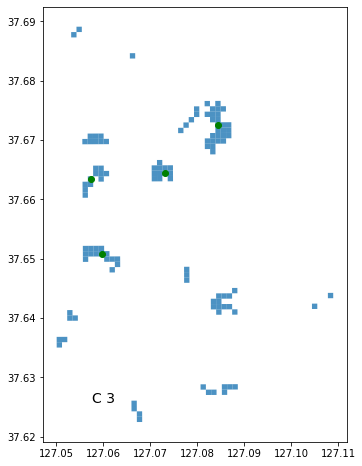

In [12]:
df_result_fin = df_result_fin.to_crs(epsg=4329)

ax = df_result_fin.plot(figsize=(8,8), alpha=0.8)
gdf.plot(ax=ax, color='green')
ax.text(0.2, 0.1, f'C 3', ha='center', va='center', fontsize=14, transform=ax.transAxes)
plt.show()

In [13]:
df_test.head()

,gid,m20,f20,m30,f30,m40,f40,m50,f50,m60,f60,m70,f70,m80+,f80+,OHCA,brpm,brpf,values,geometry,coord_cent,geo_cent
0,다사606583,34.0,19.0,24.0,9.0,20.0,20.0,37.0,29.0,33.0,35.0,10.0,19.0,0.0,13.0,0.109179,8219.3,15838.4,0.0,"POLYGON ((960600.000 1958300.000, 960600.000 1...","[960649.9999999994, 1958350.0]",POINT (960649.9999999994 1958350)
1,다사610632,16.0,23.0,32.0,26.0,29.0,28.0,23.0,25.0,24.0,40.0,10.0,19.0,7.0,18.0,0.134881,10387.6,19141.6,0.0,"POLYGON ((961000.000 1963200.000, 961000.000 1...","[961049.9999999999, 1963250.0]",POINT (961049.9999999999 1963250)
2,다사613593,7.0,9.0,11.0,7.0,18.0,10.0,29.0,17.0,19.0,32.0,20.0,26.0,14.0,18.0,0.161914,14983.0,18397.9,0.0,"POLYGON ((961300.000 1959300.000, 961300.000 1...","[961350.0000000001, 1959350.0000000005]",POINT (961350.0000000001 1959350)
3,다사613614,15.0,31.0,23.0,34.0,12.0,23.0,16.0,26.0,10.0,16.0,0.0,15.0,0.0,11.0,0.062746,2643.3,12893.4,0.0,"POLYGON ((961300.000 1961400.000, 961300.000 1...","[961349.9999999991, 1961449.9999999995]",POINT (961349.9999999991 1961450)
4,다사615630,43.0,29.0,19.0,14.0,34.0,45.0,43.0,41.0,31.0,34.0,11.0,9.0,0.0,0.0,0.089203,8985.3,8804.3,0.0,"POLYGON ((961500.000 1963000.000, 961500.000 1...","[961549.9999999999, 1963050.0000000005]",POINT (961549.9999999999 1963050)


# Visulization

In [14]:
df_test = df_test.to_crs(epsg=4329)
df_test.head()

,gid,m20,f20,m30,f30,m40,f40,m50,f50,m60,f60,m70,f70,m80+,f80+,OHCA,brpm,brpf,values,geometry,coord_cent,geo_cent
0,다사606583,34.0,19.0,24.0,9.0,20.0,20.0,37.0,29.0,33.0,35.0,10.0,19.0,0.0,13.0,0.109179,8219.3,15838.4,0.0,"POLYGON ((127.05351 37.62331, 127.05351 37.624...","[960649.9999999994, 1958350.0]",POINT (960649.9999999994 1958350)
1,다사610632,16.0,23.0,32.0,26.0,29.0,28.0,23.0,25.0,24.0,40.0,10.0,19.0,7.0,18.0,0.134881,10387.6,19141.6,0.0,"POLYGON ((127.05779 37.66749, 127.05778 37.668...","[961049.9999999999, 1963250.0]",POINT (961049.9999999999 1963250)
2,다사613593,7.0,9.0,11.0,7.0,18.0,10.0,29.0,17.0,19.0,32.0,20.0,26.0,14.0,18.0,0.161914,14983.0,18397.9,0.0,"POLYGON ((127.06139 37.63235, 127.06139 37.633...","[961350.0000000001, 1959350.0000000005]",POINT (961350.0000000001 1959350)
3,다사613614,15.0,31.0,23.0,34.0,12.0,23.0,16.0,26.0,10.0,16.0,0.0,15.0,0.0,11.0,0.062746,2643.3,12893.4,0.0,"POLYGON ((127.06128 37.65128, 127.06128 37.652...","[961349.9999999991, 1961449.9999999995]",POINT (961349.9999999991 1961450)
4,다사615630,43.0,29.0,19.0,14.0,34.0,45.0,43.0,41.0,31.0,34.0,11.0,9.0,0.0,0.0,0.089203,8985.3,8804.3,0.0,"POLYGON ((127.06347 37.66571, 127.06346 37.666...","[961549.9999999999, 1963050.0000000005]",POINT (961549.9999999999 1963050)


In [15]:
gdf

,lon,lat,geom
0,127.073111,37.664389,POINT (127.07311 37.66439)
1,127.057243,37.663429,POINT (127.05724 37.66343)
2,127.084403,37.672541,POINT (127.08440 37.67254)
3,127.059585,37.650819,POINT (127.05958 37.65082)


In [16]:
lats = np.array(gdf.lat)
lons = np.array(gdf.lon)
lat_mean = lats.mean()
lon_mean = lons.mean()

In [17]:
m2 = folium.Map([lat_mean, lon_mean], zoom_start = 14)

In [18]:
for lat, lon in zip(lats, lons):
    try:
        folium.Marker(location = [lat, lon],icon=folium.Icon(color='red',icon='info-sign' )).add_to(m2) # inforamtion popup
    except:
        continue

In [19]:
m2